<a href="https://colab.research.google.com/github/HalyshAnton/Python-AI/blob/AI_3_lesson/optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Підбір гіперпараметрів

Підбір гіперпараметрів - це **необхідний крок** в машинному навчанні, який може **істотно вплинути** на продуктивність вашої моделі. Цей гайд допоможе вам
зрозуміти основи підбору гіперпараметрів, а також дасть **більш детальну інформацію**
про ключові аспекти цього процесу:



# Недонавчання та перенавчання

## Недонавчання

* Виникає, коли модель **не може вивчити базові закономірності** в даних.
* В результаті модель **погано генерує прогнози** на нових даних.
* **Ознаки недонавчання:**
    * Низька точність на тренувальному та тестовому наборах даних
    * Велика різниця в продуктивності на тренувальному та тестовому наборах
* **Як виправити недонавчання:**
    * Збільшити складність моделі (наприклад, збільшити глибину дерева)
    * Збільшити обсяг даних для навчання
    * Зменшити регуляризацію



## Перенавчання

* Виникає, коли модель **занадто добре запам'ятовує тренувальні дані**,
    включаючи шум, і **не може добре працювати** з новими даними.
* **Ознаки перенавчання:**
    * Висока точність на тренувальному наборі даних, але низька на тестовому
    * Збільшення продуктивності при зменшенні складності моделі
* **Як виправити перенавчання:**
    * Зменшити складність моделі (наприклад, зменшити глибину дерева)
    * Збільшити регуляризацію
    * Використовувати dropout
    * Застосувати ранню зупинку

![](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F4533747%2F61b58caa4e9b00ead191242796e86e27%2Ffitting.JPG?generation=1594728310000042&alt=media)

# Гіперпараметри vs параметри

## Гіперпараметри

* **Конфігурують модель навчання**,
    наприклад, швидкість навчання, кількість дерев, розмір пакету.
* **Їх не навчають з даних.**
* **Впливають на процес навчання та загальну продуктивність моделі.**
* **Приклад:** глибина дерева, Кількість листків, тощо



## Параметри

* **Навчаються з даних**,
    наприклад, вузли дерева
* **Оновлюються під час тренування моделі.**
* **Впливають на прогнози, які робить модель.**

![](https://miro.medium.com/v2/resize:fit:3076/1*FIIGhzbuTo2vI62mFcbMTg.png)

# Як обрати найкращі гіперпараметри?

## Ручний підбір

* **Виберіть набір гіперпараметрів**,
    навчіть модель і оцініть її продуктивність.
* **Повторіть процес** з іншими наборами гіперпараметрів,
    поки не знайдете найкращий.
* **Переваги:**
    * Не потребує додаткових інструментів
    * Дає розуміння впливу кожного гіперпараметра
* **Недоліки:**
    * Може бути трудомістким
    * Не гарантує знаходження оптимальних значень



## Пошук сітки

* **Систематично перевірте всі можливі комбінації значень гіперпараметрів.**
* **Переваги:**
    * Гарантує знаходження кращих гіперпараметрів
* **Недоліки:**
    * Може бути дуже обчислювально витратним
    * Не гнучкий

![](https://miro.medium.com/v2/resize:fit:612/0*QKZG5I3autl1HvlY.png)

## Методи байєсійської оптимізації

* **Використовуйте метод, такий як Optuna,
    для ефективного пошуку оптимальних значень гіперпараметрів.**
* **Переваги:**
    * Ефективно шукає оптимальні гіперпараметри
    * Автоматично зупиняє пошук, коли знаходить хороші результати
    * Може використовуватися з різними моделями машинного навчання
* **Недоліки:**
    * Може бути складним для початківців
    * Потребує базових знань статистики

# Інсталяція модуля

In [37]:
!pip install -q optuna

# Дані
Ціни на діаманти

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics
import lightgbm as lgb
import optuna

In [39]:
df = pd.read_csv("https://raw.githubusercontent.com/HalyshAnton/IT-Step-Pyton-AI/main/module3/data/diamonds2.csv",
                 index_col=0
                 )

In [40]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [41]:
df['price'].describe()

count    53943.000000
mean      3932.734294
std       3989.338447
min        326.000000
25%        950.000000
50%       2401.000000
75%       5324.000000
max      18823.000000
Name: price, dtype: float64

# Побудова моделі

## Поділ даних

In [42]:
y = df['price']
X = df.drop(columns='price')

## train, val та test data

Під час пошуку гіперпараметрів за допомогою Optuna використання трьох наборів даних - train, val та test -
є **необхідною умовою** для отримання **точних та надійних результатів**. Ось чому:

**1. Train data:**

* Використовується для **навчання моделі**.
* Містить дані, на яких модель буде **вивчати закономірності**.
* **Не повинне використовуватися** для оцінки продуктивності моделі
    під час пошуку гіперпараметрів, адже модель
    може просто запам'ятати
    ці дані,
    що призведе до перенавчання.

**2. Val data:**

* Використовується для **оцінки продуктивності моделі**
    під час пошуку гіперпараметрів.
* **Не повинне використовуватися** для
    навчання моделі.
* Дозволяє **моделювати процес**
    узагальнення на нові дані.
* Забезпечує **більш об'єктивну оцінку**
    продуктивності моделі,
    ніж оцінка на тренувальному наборі.

**3. Test data:**

* Використовується для **оцінки остаточної продуктивності моделі**
    після вибору найкращих гіперпараметрів.
* **Не використовується** ні для навчання, ні
    для налаштування гіперпараметрів.
* Забезпечує **найточнішу оцінку**
    продуктивності моделі
    на **незалежних** даних.

**Важливо:**

* Розмір та розподіл даних
    в **train, val та test**
    наборах
    **повинні бути подібними**.
* **Val data**
    **не повинне**
    **перетинатися**
    з **test data**.

**Використання трьох наборів даних**
дозволяє Optuna:

* **Уникнути перенавчання**
    та отримати
    **точні оцінки**
    продуктивності моделі.
* **Об'єктивно порівняти**
    різні набори гіперпараметрів.
* **Вибрати найкращі гіперпараметри**,
    які
    **узагальнюються**
    на нові дані.





In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  train_size=0.6/0.8,
                                                  random_state=42)

print(f'Train: {X_train.shape[0]} samples \t {round(X_train.shape[0] / X.shape[0] * 100)}%')
print(f'Test:  {X_test.shape[0]} samples \t {round(X_test.shape[0] / X.shape[0] * 100)}%')
print(f'Val:   {X_val.shape[0]} samples \t {round(X_val.shape[0] / X.shape[0] * 100)}%')

Train: 32365 samples 	 60%
Test:  10789 samples 	 20%
Val:   10789 samples 	 20%


## Створення Pipeline

In [44]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

In [45]:
num_columns = X.select_dtypes(include="number").columns
cat_columns = X.select_dtypes(include="object").columns

# числові ознаки
num_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median"))]
    )

# категоріальні ознаки
cat_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")),
           ("encoder", OneHotEncoder(sparse_output=False))])

# об'єднання двох pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_columns),
        ("cat", cat_transformer, cat_columns),
    ]
)

preprocessor.set_output(transform='pandas')
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 Index(['carat', 'depth', 'table', 'x', 'y', 'z'], dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(sparse_output=False))]),
                                 Index(['cut', 'color', 'clarity'], dtype='object'))])

# Попередня обробка даних

Оскільки ми користуємось новою бібліотекою, то нам потрібно поередньо натренувати `preprocessor` та обробити дані

In [46]:
# навчання препроцесора
X_train = preprocessor.fit_transform(X_train)

# обробка даних
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

# Optuna

## Функція objective

Функція `objective` - це ключовий компонент вашого коду, де ви:

1. **Визначаєте модель LightGBMRegressor:**
    - Створюєте екземпляр `LightGBMRegressor` з бажаними параметрами.
2. **Навчаєте модель на тренувальному наборі даних:**
    - Використовуєте метод `fit` для навчання моделі на ваших тренувальних даних.
3. **Оцінюєте модель на тестовому наборі даних:**
    - Використовуєте метод `predict` для отримання прогнозів на тестовому наборі.
    - Рахуєте метрику оцінки,
        наприклад, RMSE (Root Mean Squared Error) або MAE (Mean Absolute Error),
        щоб оцінити точність моделі.
4. **Повертаєте значення метрики:**
    - Функція `objective` повинна повернути значення метрики
        (чим менше, тим краще).




In [133]:
from sklearn import metrics


def objective(trial):
  """
  Функція objective для Optuna, яка навчає модель LightGBMRegressor
  на тренувальному наборі даних та оцінює її на тестовому наборі.

  Args:
      trial (optuna.Trial): Об'єкт Optuna, що представляє один набір гіперпараметрів.

  Returns:
      float: Значення метрики оцінки (R2).
  """

  # 1. Визначення гіперпараметрів:

  params = {
        'objective': 'mse',
        'n_estimators': 30,
        'verbose': -1,
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

  # 2. Створення моделі LightGBMRegressor:

  model = lgb.LGBMRegressor(**params)

  # 3. Навчання моделі на тренувальному наборі даних:

  model.fit(X_train, y_train)

  # 4. Оцінка моделі на тестовому наборі даних:

  y_pred = model.predict(X_val)
  r2 = metrics.r2_score(y_val, y_pred)

  # 5. Повернення значення метрики:
  return r2

## Об'єкт trial

**Trial** - це об'єкт, що використовується Optuna для представлення
одного набору гіперпараметрів. Він надає доступ до методів для
пропозиції значень гіперпараметрів:

* **suggest_float(name, low, high):**
    Випадково генерує значення float в діапазоні `[low, high]` для гіперпараметра `name`.
* **suggest_int(name, low, high):**
    Випадково генерує значення integer в діапазоні `[low, high]` для гіперпараметра `name`.
* **suggest_categorical(name, categories):**
    Випадково вибирає категорію з списку `categories` для гіперпараметра `name`.





### Параметр log:

* `log` - це параметр, який використовується
    з `suggest_float` для
    визначення того, чи використовувати логарифмічну шкалу
    при генеруванні значень.
* **True:**
    * Значення генеруються в логарифмічній шкалі
      в діапазоні `[math.exp(low), math.exp(high)]`.
    * Це може бути корисно для
      гіперпараметрів, які мають
      великий діапазон значень
      або експоненційну залежність.
* **False:**
    * Значення генеруються
      рівномірно в діапазоні `[low, high]`.

## Запуск оптимізації

Після визначення функції `objective` ви можете запустити оптимізацію
за допомогою `study`:


* `study` - це об'єкт, який зберігає інформацію про
    проведені випробування та знайдені гіперпараметри.
* `create_study(direction)` створює нове дослідження
    з заданим напрямком оптимізації (`minimize` або `maximize`).
* `optimize(objective, n_trials)` запускає оптимізацію
    за допомогою функції `objective` протягом `n_trials`
    випробувань.

In [134]:
#optuna.logging.set_verbosity(optuna.logging.WARNING) # щоб не виводило інформацію про trial

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2024-07-11 18:50:30,043] A new study created in memory with name: no-name-964f58bc-7507-4daa-b34e-63e829bda353
[I 2024-07-11 18:50:30,652] Trial 0 finished with value: 0.9748693697799978 and parameters: {'boosting_type': 'dart', 'lambda_l1': 1.4825925493046013, 'lambda_l2': 0.03695281237683543, 'num_leaves': 184, 'feature_fraction': 0.8773195836660315, 'bagging_fraction': 0.8719648173105772, 'bagging_freq': 3, 'min_child_samples': 31}. Best is trial 0 with value: 0.9748693697799978.
[I 2024-07-11 18:50:30,941] Trial 1 finished with value: 0.9617457821206415 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 0.41011983486847514, 'lambda_l2': 1.1663478749172203e-08, 'num_leaves': 30, 'feature_fraction': 0.4658753131524789, 'bagging_fraction': 0.7623993071322792, 'bagging_freq': 7, 'min_child_samples': 95}. Best is trial 0 with value: 0.9748693697799978.
[I 2024-07-11 18:50:31,244] Trial 2 finished with value: 0.9739832918578013 and parameters: {'boosting_type': 'gbdt', 'lambda_l1'

## Результат

In [135]:
print(f"найкраща метрика: {study.best_value}")

найкраща метрика: 0.9801568963547465


In [140]:
best_params = study.best_params

model = lgb.LGBMRegressor(**best_params,
                          objective = 'mse',
                          n_estimators = 100,
                          verbose=-1)

model.fit(X_train, y_train,
          eval_set=[(X_test, y_test), (X_train, y_train)],
          eval_metric='mae')

LGBMRegressor(bagging_fraction=0.7693151189411407, bagging_freq=7,
              feature_fraction=0.980947700651865,
              lambda_l1=6.077544605357751e-08, lambda_l2=3.231993581819831e-08,
              min_child_samples=50, num_leaves=182, objective='mse',
              verbose=-1)

# Метрики

In [141]:
def get_metrics(y_true, y_pred, name="model"):
  df = pd.DataFrame()

  df.loc["MAE", name] = metrics.mean_absolute_error(y_true, y_pred)
  df.loc["RMSE", name] = metrics.mean_squared_error(y_true, y_pred) ** 0.5
  df.loc["R2", name] = metrics.r2_score(y_true, y_pred)

  return df.round(2)

In [142]:
all_metrics = pd.DataFrame()

all_metrics["train"] = get_metrics(y_train, model.predict(X_train))
all_metrics["test"] = get_metrics(y_test, model.predict(X_test))

all_metrics

,train,test
MAE,229.03,270.67
RMSE,439.86,540.19
R2,0.99,0.98


## Важливість гіперпараметрів

In [143]:
optuna.visualization.plot_param_importances(study)

## Важливість ознак

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

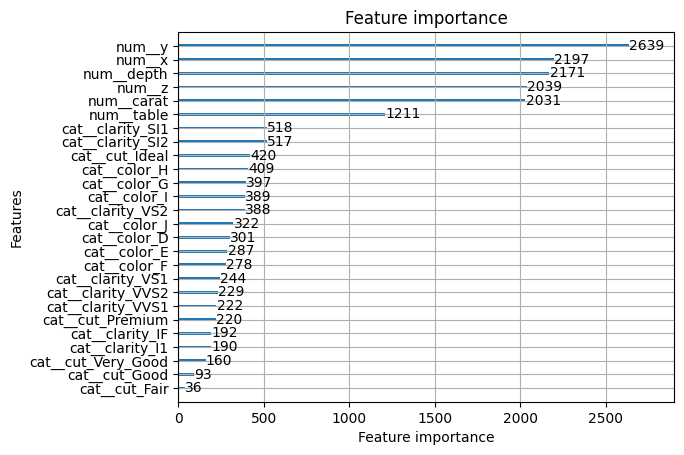

In [144]:
lgb.plot_importance(model)

## Train vs Тест

In [145]:
len(model.evals_result_['training']['l1'])

100

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='l1'>

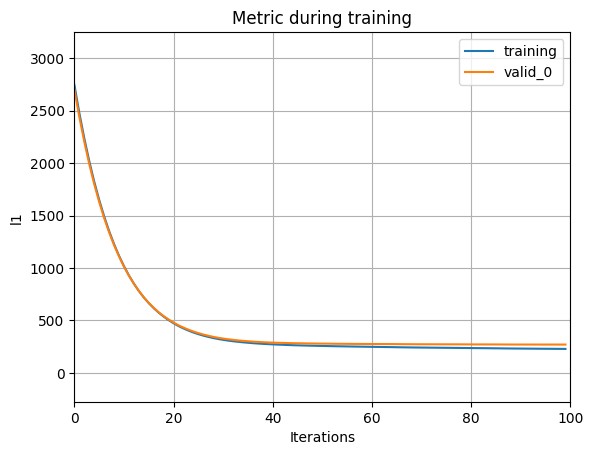

In [146]:
lgb.plot_metric(model,
                metric='l1')

# Збереження моделі

In [147]:
model = Pipeline(
    [("prep", preprocessor),
     ("model", model)
     ]
)

model

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['carat', 'depth', 'table', 'x', 'y', 'z'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  Index(['cut', 'color', 'clarity'], dtype='object'))])),
                ('model',
                 LGBMRegressor(bagging_fraction=0.7693151189411407,
                               bagging_freq=7,
                               feature_fraction=0.980947700651865,
                               lambda_l1=6.077544605357751e-08,
                               lambda_l2=3.231993581819831e-08,
                               min_child_samples=50, num_leaves=182,
                               objective='mse', verbose=-1))])

# Декілька моделей

In [149]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor


def objective(trial):
  """
  Функція objective для Optuna, яка навчає модель LightGBMRegressor
  на тренувальному наборі даних та оцінює її на тестовому наборі.

  Args:
      trial (optuna.Trial): Об'єкт Optuna, що представляє один набір гіперпараметрів.

  Returns:
      float: Значення метрики оцінки (R2).
  """

  model_type = trial.suggest_categorical("model_type", ['LinReg', 'DT', 'LGBM'])

  if model_type == 'LinReg':
    model = LinearRegression()

  elif model_type == 'DT':
    model = DecisionTreeRegressor(
        max_depth = trial.suggest_int('max_depth', 2, 12),
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 5, 100)
    )

  elif model_type == 'LGBM':
    model = lgb.LGBMRegressor(
        objective = 'mse',
        verbose=-1,
        n_estimators=20,
        boosting_type=trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        lambda_l1 = trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        lambda_l2 = trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        num_leaves = trial.suggest_int('num_leaves', 2, 256),
        feature_fraction = trial.suggest_float('feature_fraction', 0.4, 1.0),
        bagging_fraction = trial.suggest_float('bagging_fraction', 0.4, 1.0),
        bagging_freq = trial.suggest_int('bagging_freq', 1, 7),
        min_child_samples = trial.suggest_int('min_child_samples', 5, 100),


    )

  # Навчання моделі на тренувальному наборі даних:

  model.fit(X_train, y_train)

  # Оцінка моделі на тестовому наборі даних:

  y_pred = model.predict(X_val)
  r2 = metrics.r2_score(y_val, y_pred)

  # Повернення значення метрики:
  return r2

In [150]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2024-07-11 18:51:32,540] A new study created in memory with name: no-name-c959e0b6-504b-43fa-9257-5aeadda7063f
[I 2024-07-11 18:51:32,676] Trial 0 finished with value: 0.9300809644023181 and parameters: {'model_type': 'DT', 'max_depth': 6, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.9300809644023181.
[I 2024-07-11 18:51:32,786] Trial 1 finished with value: 0.916173263803184 and parameters: {'model_type': 'DT', 'max_depth': 5, 'min_samples_leaf': 90}. Best is trial 0 with value: 0.9300809644023181.
[I 2024-07-11 18:51:32,846] Trial 2 finished with value: 0.8334953858598501 and parameters: {'model_type': 'DT', 'max_depth': 2, 'min_samples_leaf': 37}. Best is trial 0 with value: 0.9300809644023181.
[I 2024-07-11 18:51:32,952] Trial 3 finished with value: 0.9173599381529961 and parameters: {'model_type': 'DT', 'max_depth': 5, 'min_samples_leaf': 17}. Best is trial 0 with value: 0.9300809644023181.
[I 2024-07-11 18:51:33,300] Trial 4 finished with value: 0.9604470757681713 and 

In [151]:
study.best_value

0.9604470757681713

In [152]:
study.best_params

{'model_type': 'LGBM',
 'boosting_type': 'gbdt',
 'lambda_l1': 6.483653894547036e-07,
 'lambda_l2': 1.928149766528227e-08,
 'num_leaves': 137,
 'feature_fraction': 0.7895473365089889,
 'bagging_fraction': 0.9519035163847861,
 'bagging_freq': 7,
 'min_child_samples': 72}

# Додатково(оптимізація по декільком метрикам)

Optuna дозволяє шукати гіперпараметри, які оптимізують не одну, а одразу декілька метрик.

Для цього потрібно внести дві зміни:
* objective повинна повертати список значень
* optuna.create_study потрібно вказати параметр directions зі списком напрямків для кожної метрики

In [153]:
def objective(trial):
  """
  Функція objective для Optuna, яка навчає модель LightGBMRegressor
  на тренувальному наборі даних та оцінює її на тестовому наборі.

  Args:
      trial (optuna.Trial): Об'єкт Optuna, що представляє один набір гіперпараметрів.

  Returns:
      float: Значення метрики оцінки (R2).
  """

  # 1. Визначення гіперпараметрів:

  params = {
        "objective": "mse",
        "verbosity": -1,
        "n_estimators": 10,
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
        'learning_rate': trial.suggest_float('learning_rate', 1e-8, 1.0, log=True),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
  }

  # 2. Створення моделі LightGBMRegressor:

  model = lgb.LGBMRegressor(**params)

  # 3. Навчання моделі на тренувальному наборі даних:

  model.fit(X_train, y_train)

  # 4. Оцінка моделі на тестовому наборі даних:

  y_pred = model.predict(X_val)

  r2 = metrics.r2_score(y_val, y_pred)
  mae = metrics.mean_absolute_error(y_val, y_pred)
  rmse = metrics.mean_squared_error(y_val, y_pred) ** 0.5


  # 5. Повернення значення метрики:
  return r2, mae, rmse

In [154]:
study = optuna.create_study(directions=['maximize', 'minimize', 'minimize'])
study.optimize(objective, n_trials=100)

[I 2024-07-11 18:51:53,265] A new study created in memory with name: no-name-6c8ab63d-1baf-4238-8fd9-d8f144483c87
[I 2024-07-11 18:51:53,518] Trial 0 finished with values: [0.020516818446748353, 3040.3037581364197, 4004.4157655169183] and parameters: {'boosting_type': 'dart', 'learning_rate': 0.001299915377739411, 'lambda_l1': 4.950611652476449e-07, 'lambda_l2': 2.058220793012835, 'num_leaves': 91, 'feature_fraction': 0.7536386243545998, 'bagging_fraction': 0.569456506348915, 'bagging_freq': 3, 'min_child_samples': 21}. 
[I 2024-07-11 18:51:53,700] Trial 1 finished with values: [0.525168497301555, 2042.5406568161989, 2788.11339661762] and parameters: {'boosting_type': 'dart', 'learning_rate': 0.04980612765624969, 'lambda_l1': 0.23329811331057312, 'lambda_l2': 7.472868982923927, 'num_leaves': 199, 'feature_fraction': 0.6399223387069294, 'bagging_fraction': 0.45659839946371195, 'bagging_freq': 6, 'min_child_samples': 89}. 
[I 2024-07-11 18:51:53,961] Trial 2 finished with values: [7.6821

Після оптимізації замість параметру `best_params` буде `best_trials` зі списком найкращих наборів гіперпараметрів

In [155]:
len(study.best_trials)

1

In [156]:
data = pd.DataFrame([trial.values for trial in study.best_trials],
                    columns=['r2', 'mae', 'rmse'])

data

,r2,mae,rmse
0,0.984891,281.052088,497.351973


In [157]:
best_params = study.best_trials[0].params

In [158]:
best_params

{'boosting_type': 'gbdt',
 'learning_rate': 0.5366665725720335,
 'lambda_l1': 0.308952621244322,
 'lambda_l2': 0.039189743204846035,
 'num_leaves': 153,
 'feature_fraction': 0.6191992228733021,
 'bagging_fraction': 0.9297473501267735,
 'bagging_freq': 1,
 'min_child_samples': 29}

# Додатково(крос-валідація)

## Що таке крос-валідація

Крос-валідація - це **статистичний метод**, який використовується для оцінки
**продуктивності моделі машинного навчання**. Вона ґрунтується на
**повторному розділенні набору даних** на кілька **підмножин** (**фолдів**)
та **оцінці моделі на кожному з них**.

Цей метод дозволяє отримати більш **точну та надійну** оцінку
**узагальнення** моделі, тобто її здатності
**робити правильні прогнози на нових, не бачених раніше даних**.

![](https://miro.medium.com/v2/resize:fit:1200/1*AAwIlHM8TpAVe4l2FihNUQ.png)

### Як працює крос-валідація?

1. **Розділення даних:** Набір даних розділяється на **k**
    **рівномірних** підмножин (**фолдів**).

2. **Повторне навчання та оцінка:**
    * Для **кожного з k фолдів**:
        * **Навчання моделі:** Модель навчається на **об'єднанні**
          **k-1 фолдів** (**навчальний набір**).
        * **Оцінка моделі:** Прогнози моделі
          робляться на **залишковому**
          **фолді** (**тестовий набір**).
        * **Обчислення метрики:**
          Обчислюється метрика
          продуктивності моделі (наприклад,
          mse).

3. **Агрегування результатів:**
    * Обчислюється **середнє** значення
      метрики продуктивності
      **по всіх k фолдах**.

### Переваги крос-валідації:

* **Більш точна оцінка узагальнення:**
    Крос-валідація дає більш
    точну оцінку продуктивності
    моделі на нових даних,
    ніж оцінка на одному
    тестовому наборі.
* **Зменшення перенавчання:**
    Допомагає виявити та
    уникнути перенавчання
    моделі на навчальних
    даних.
* **Об'єктивне порівняння моделей:**
    Дозволяє
    об'єктивно порівнювати
    різні моделі машинного
    навчання.

### Варіації крос-валідації:

* **Простий k-fold:** Найпростіший
    варіант, де набір даних
    ділиться на k однакових
    фолдів.
* **Stratified k-fold:** Фолди
    формуються з урахуванням
    розподілу цільової
    змінної в наборі даних.
* **Leave-one-out:** Спеціальний
    випадок, де k = n (кількість
    об'єктів у наборі даних),
    і модель навчається на
    n-1 об'єктах, а
    оцінюється на
    залишковому 1.

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    random_state=42)

In [68]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [69]:
from sklearn.model_selection import KFold


def objective(trial):
  """
  Функція objective для Optuna, яка навчає модель LightGBMRegressor
  на тренувальному наборі даних та оцінює її на тестовому наборі.

  Args:
      trial (optuna.Trial): Об'єкт Optuna, що представляє один набір гіперпараметрів.

  Returns:
      float: Значення метрики оцінки (R2).
  """

  # 1. Визначення гіперпараметрів:

  params = {
        "objective": "mse",
        "verbosity": -1,
        "n_estimators": 30,
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
        'learning_rate': trial.suggest_float('learning_rate', 1e-8, 1.0, log=True),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
  }

  # 2. Створення моделі LightGBMRegressor:

  model = lgb.LGBMRegressor(**params)

  # 3. Навчання моделі за допомогою крос-валідації:

  kf = KFold(n_splits=5, shuffle=True, random_state=42)

  r2 = []

  for train_index, test_index in kf.split(X_train):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    model.fit(X_train_fold, y_train_fold)

    # 4. Оцінка моделі на тестовому наборі даних:

    y_pred = model.predict(X_test_fold)

    r2.append(metrics.r2_score(y_test_fold, y_pred))


  # 5. Повернення усередненої метрики:
  return np.mean(r2)

In [70]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2024-07-11 18:39:06,104] A new study created in memory with name: no-name-d120b272-20e5-4824-b214-b36fc9c92ae6
[I 2024-07-11 18:39:09,351] Trial 0 finished with value: 0.18761302142677075 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.004418930047602831, 'lambda_l1': 5.329256971923847, 'lambda_l2': 2.6200724016612564e-06, 'num_leaves': 234, 'feature_fraction': 0.9003623148941915, 'bagging_fraction': 0.7660486167341256, 'bagging_freq': 5, 'min_child_samples': 47}. Best is trial 0 with value: 0.18761302142677075.
[I 2024-07-11 18:39:11,779] Trial 1 finished with value: 0.005626590785676289 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.00010657028985870083, 'lambda_l1': 0.014468706231880887, 'lambda_l2': 0.00024858260767818155, 'num_leaves': 174, 'feature_fraction': 0.5933909942038416, 'bagging_fraction': 0.7533476819911014, 'bagging_freq': 1, 'min_child_samples': 74}. Best is trial 0 with value: 0.18761302142677075.
[I 2024-07-11 18:39:13,968] Trial 2 fini

In [71]:
study.best_value

0.97934553454755